In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import igraph as ig
from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)
time_start = datetime.now()

In [3]:
import sys
sys.path.append('../..')

from src.configs import config
from src.utils import utils as us
from src.utils import visualise as vs
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("once")

# Data Load

In [4]:
adata = sc.read(config.PATHS.LOGS/'Reduced.h5ad')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/vess/cdata/HumanTechnopole/datasets/LOGS/SUBSET_1/Reduced.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# 3. Clustering

We use graph-based clustering algorithms, that, starting from neighbourhood graph, aim at identifying “communities” of cells that are more connected to cells in the same community than they are to cells of different communities. Each community represents a cluster that is then subjected to downstream characterization.

Here we test Leiden algorithm (reference paper). Advantages: computationally efficient; solves issue of detection of badly connected communities that somentimes happens with Louvain algorithm.

Different resolution values are tested; lower values results in a smaller number of bigger clusters, while higher values detect a bigger number of small clusters.


## 3.1 Test resolutions with Leiden

In [5]:
res = [0.2, 0.4, 0.6, 0.8, 1, 1.2]
leiden_labels = []

for x in res:
    label = "Leiden_" + str(x).replace('.', '')
    leiden_labels.append(label) 
    sc.tl.leiden(adata, resolution = x, key_added= label)

running Leiden clustering
    finished: found 11 clusters and added
    'Leiden_02', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 14 clusters and added
    'Leiden_04', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 17 clusters and added
    'Leiden_06', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 23 clusters and added
    'Leiden_08', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 24 clusters and added
    'Leiden_1', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 26 clusters and added
    'Leiden_12', the cluster labels (adata.obs, categorical) (0:00:09)


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/con

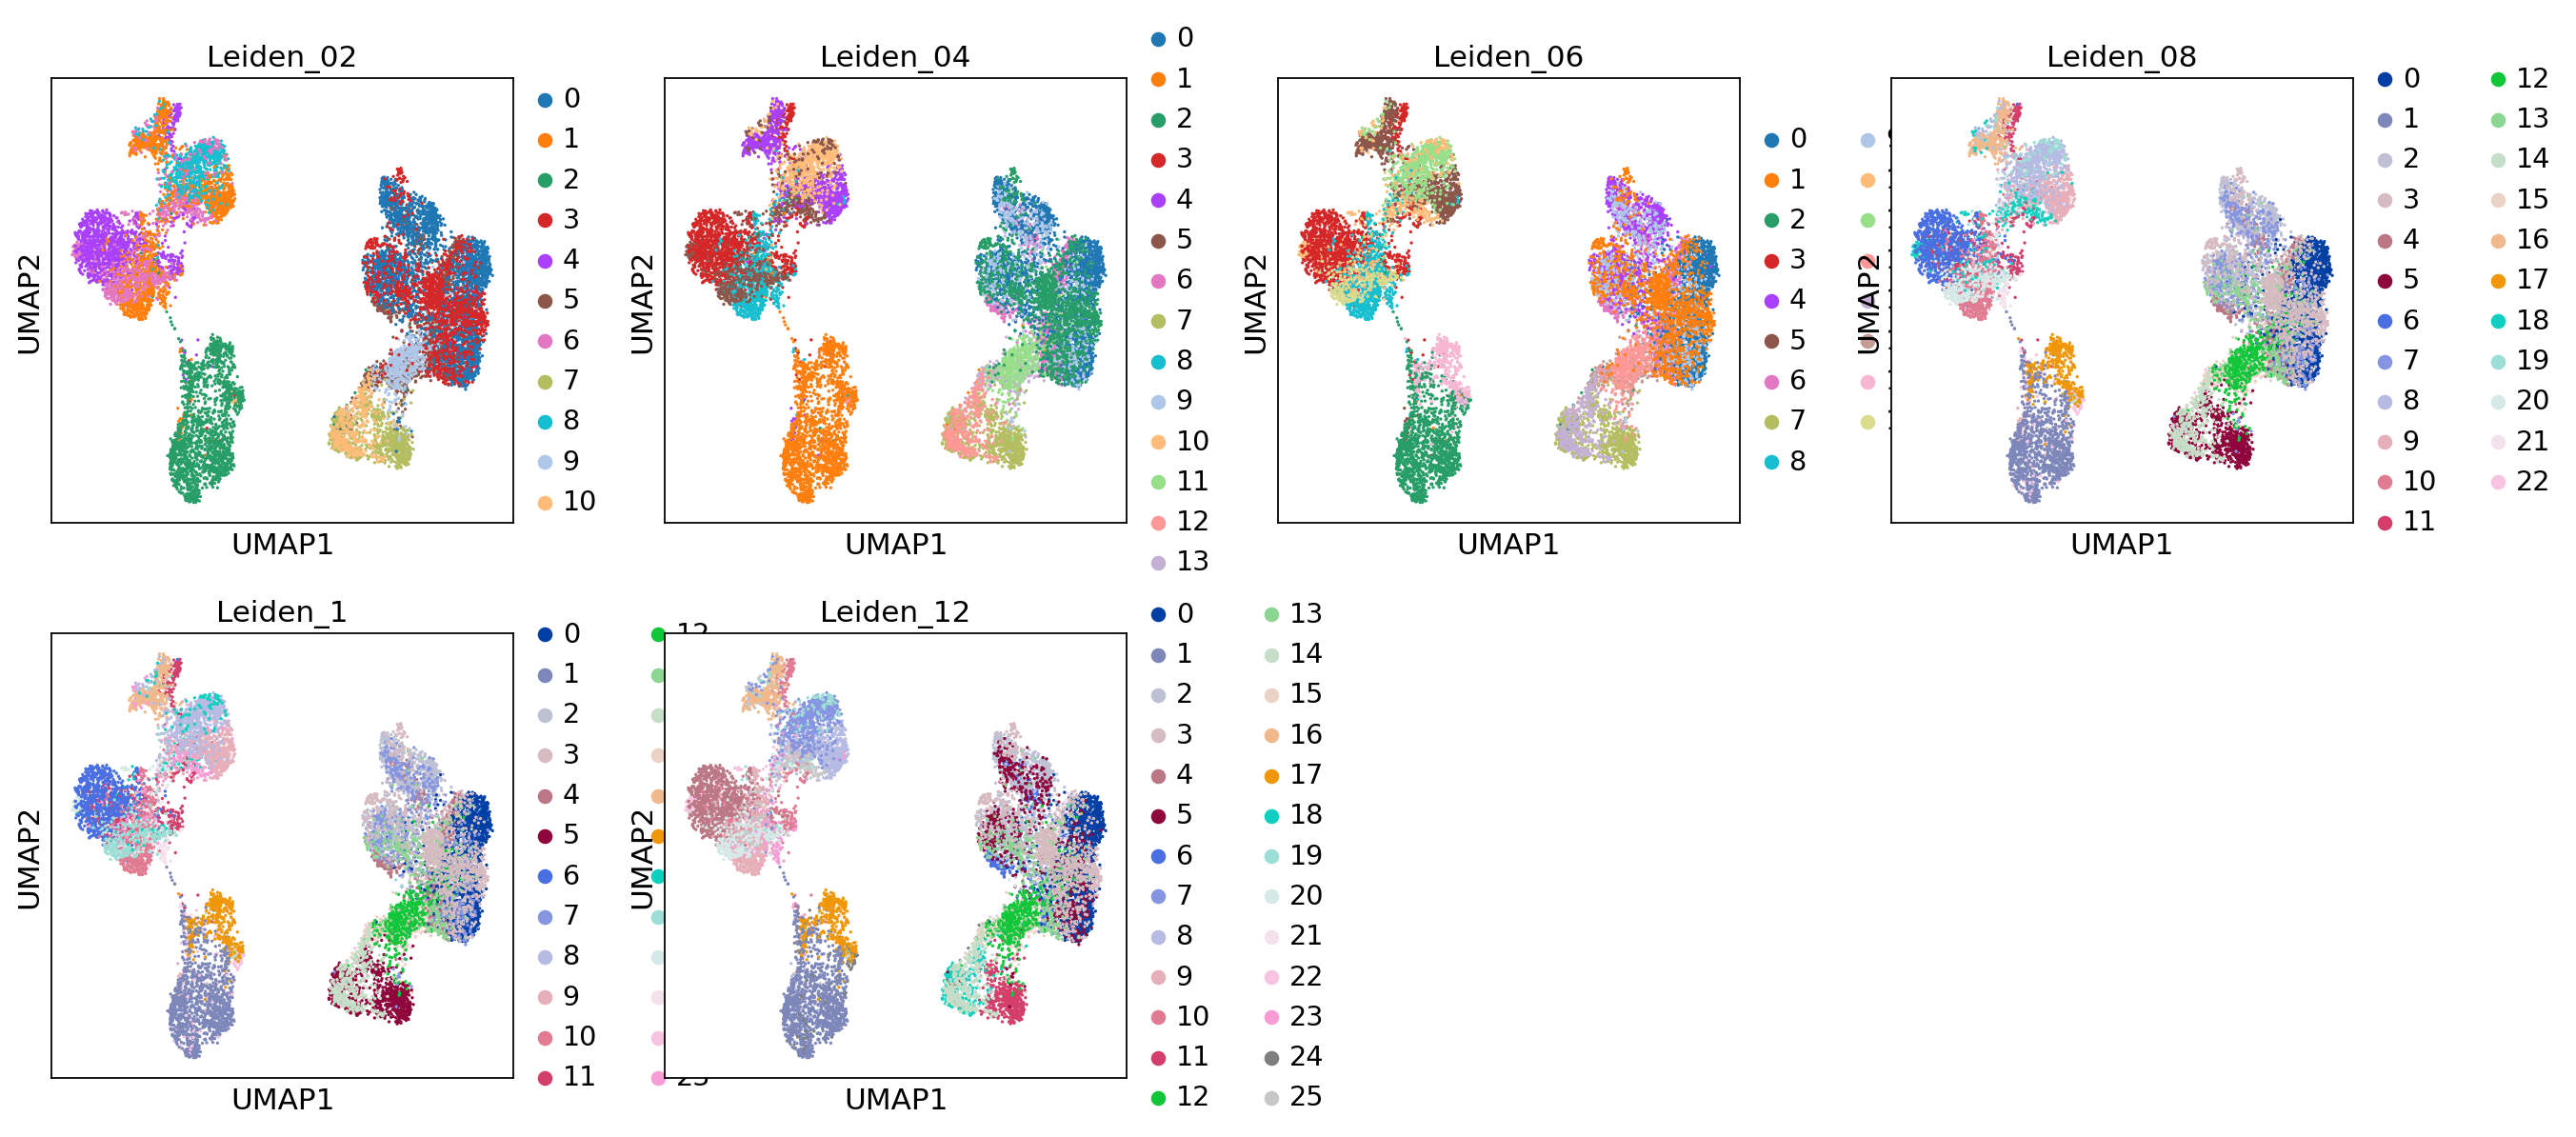

In [6]:
sc.pl.umap(adata, color=leiden_labels)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/con

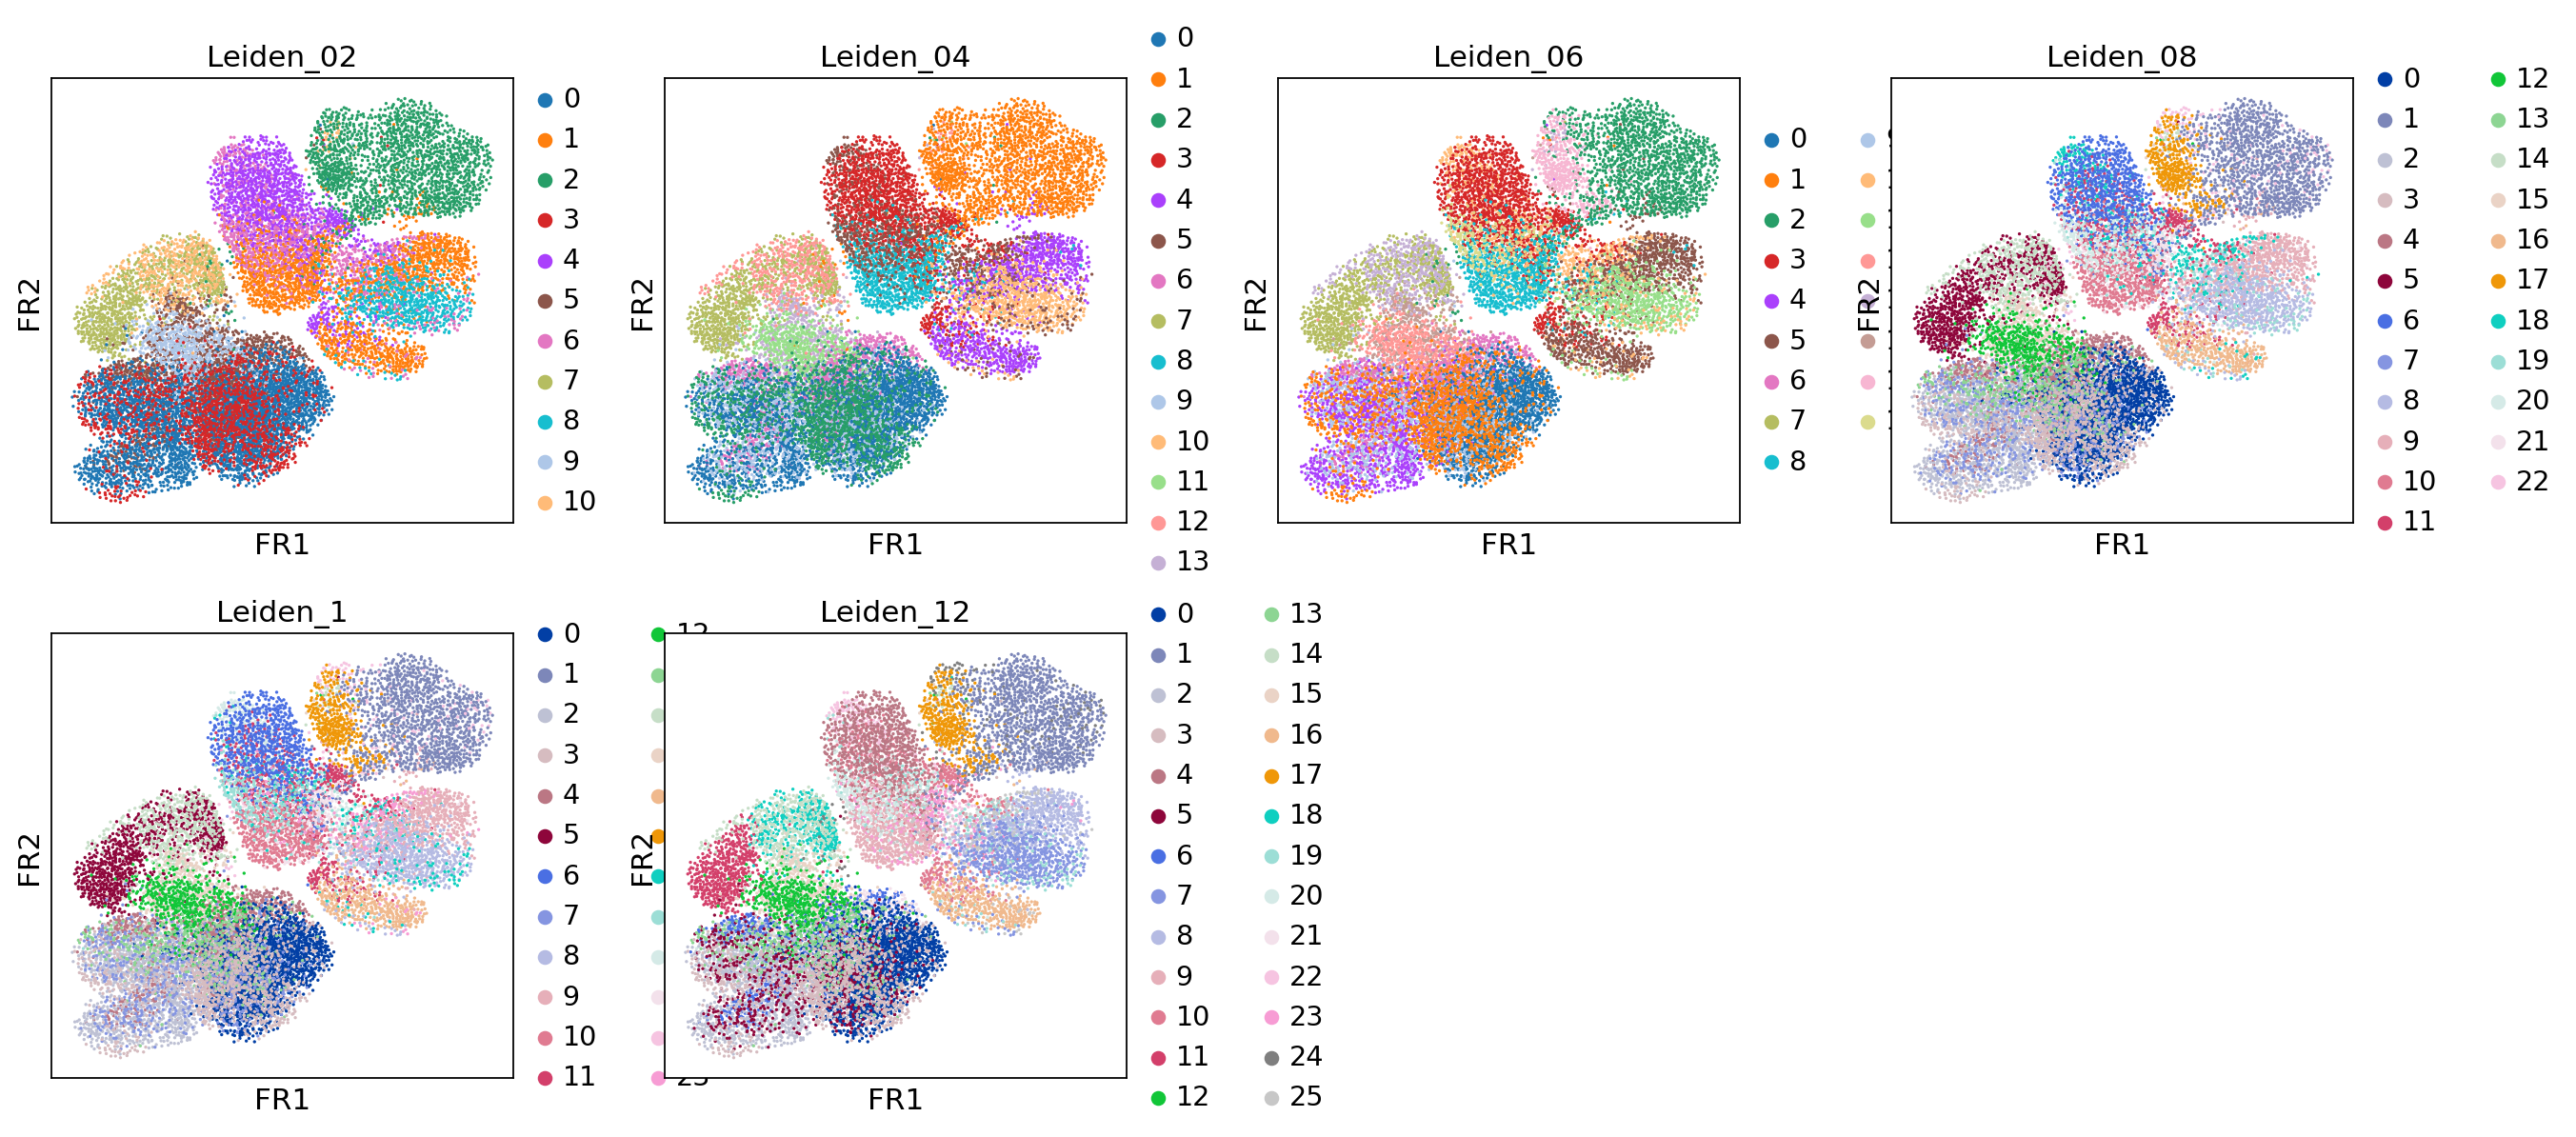

In [7]:
sc.pl.draw_graph(adata, color=leiden_labels)

## 3.2 Choose granularity

In [8]:
chosen_leiden = 'Leiden_06'
key_leiden = 'rank_L' + chosen_leiden[-2:]

adata.obs['FinalLeiden'] = adata.obs['Leiden_06']
adata.obs['FinalLeiden'].value_counts()

FinalLeiden
0     1345
1     1304
2     1276
3     1254
4      982
5      935
6      809
7      801
8      724
9      723
10     704
11     573
12     455
13     393
14     374
15     361
16     229
Name: count, dtype: int64

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


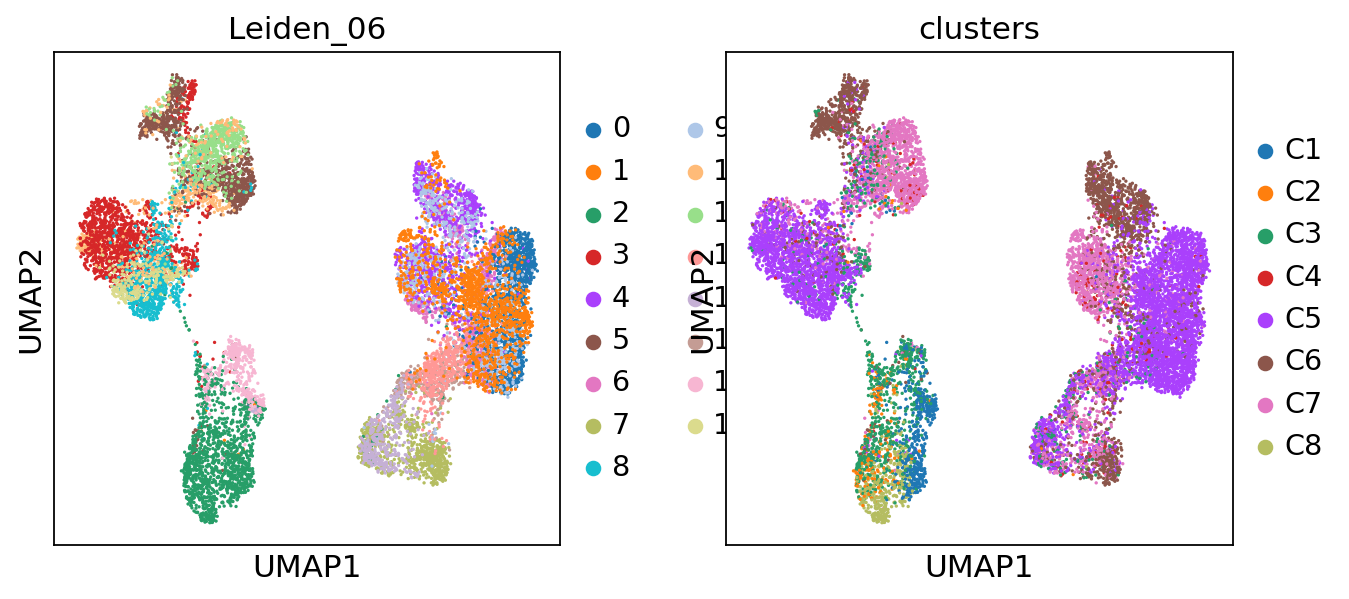

In [9]:
sc.pl.umap(adata, color=['Leiden_06', 'clusters'])

In [10]:
pd.crosstab(adata.obs['clusters'], adata.obs['FinalLeiden'], margins=True)

FinalLeiden     0     1     2     3    4    5    6    7    8    9   10   11  \
clusters                                                                      
C1              0     1   318     4    1    0    0    4    6    1   12    7   
C2              0     0   146     3    0    0    0    4    0    0   10    4   
C3              3    22   396    99    4    4   10   91   74    4   71   89   
C4             17     6     1    28   36   49   32   27    4   32    8   21   
C5           1281   867     9   754   59   34  496  224  590  378  293   24   
C6             22   125    42   158  539  345  140  210   27  198   72   60   
C7             22   283     3   208  343  503  131  240   23  110  236  366   
C8              0     0   361     0    0    0    0    1    0    0    2    2   
All          1345  1304  1276  1254  982  935  809  801  724  723  704  573   

FinalLeiden   12   13   14   15   16    All  
clusters                                     
C1             0   19    3  105    0    481  
C2             0    1    0   38    0    206  
C3            22   24   39  193   11   1156  
C4            13    8   23    4    0    309  
C5           268  181  194    2  210   5864  
C6            52   61   61    6    8   2126  
C7           100   99   54    6    0   2727  
C8             0    0    0    7    0    373  
All          455  393  374  361  229  13242

# 4. Top markers

In [11]:
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, groupby='FinalLeiden', method='wilcoxon', key_added='rank_L06', 
                       use_raw=False)

ranking genes
    finished: added to `.uns['rank_L06']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


In [12]:
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, groupby='FinalLeiden', method='wilcoxon', key_added='rank_L06', 
                       use_raw=False)

ranking genes
    finished: added to `.uns['rank_L06']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_FinalLeiden']`


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


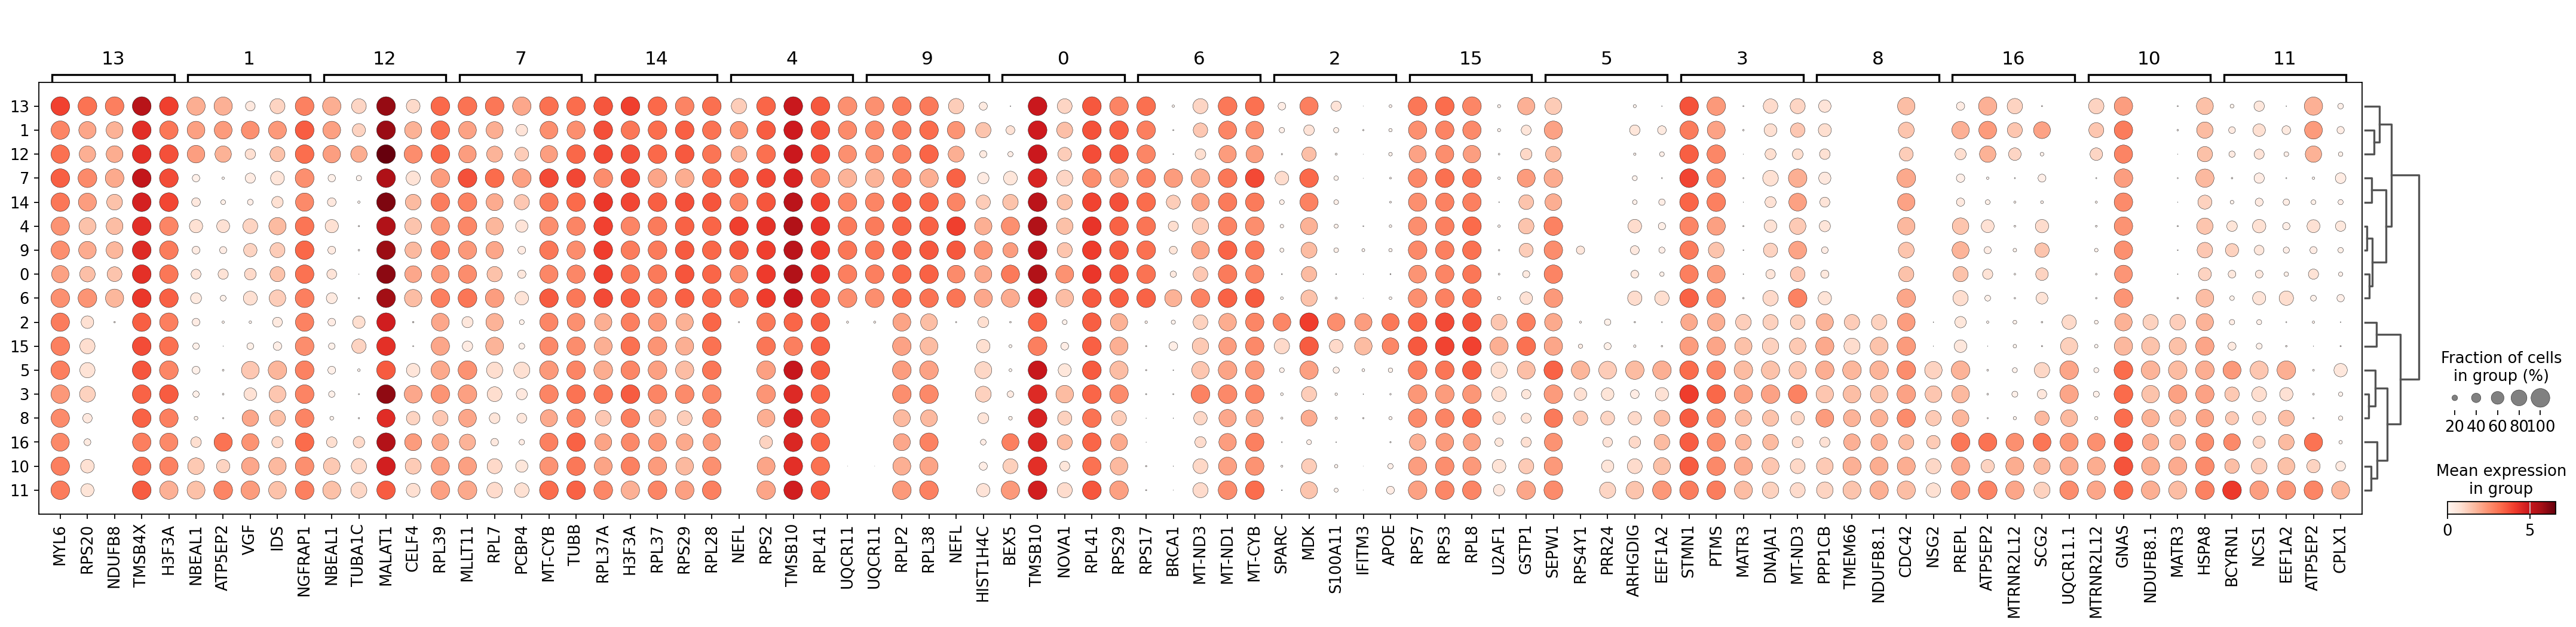

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key='rank_L06')

# 5. Functional analysis on top markers

In [15]:
def CustomGO(adata, cluster, rank, n_markers=40,  show=10):
    """  
        GO analysis with GProfiler for cluster top-marker genes.
    """
    
    GroupMarkers = pd.DataFrame(adata.uns[rank]['names']).head(n_markers)   
    q = GroupMarkers[cluster].tolist()
    u = adata.var_names.tolist()
    return gp.profile(organism='hsapiens', sources=['GO:BP', 'GO:CC'], query=q, 
           background=u, no_iea=True).head(show)

gp = GProfiler(return_dataframe=True)

Cl = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

for i in Cl: 
    print("\n\n {}".format(i)) 
    display(CustomGO(adata, cluster=i, rank=key_leiden, n_markers=40,  show=8))

NameError: name 'GProfiler' is not defined

# 6. Save

In [14]:
adata.write(results_file)
print(datetime.now())

2023-08-04 22:48:16.404379
